In [ ]:
import biotite.sequence as biotite_seq
import biotite.sequence.align as align
substitution_matrix = align.SubstitutionMatrix.std_nucleotide_matrix()
import glob
import pandas as pd
import wandb
import itertools
import torch
import numpy as np
import os
import matplotlib.pyplot as plt
from matplotlib.cm import coolwarm
from matplotlib.colors import Normalize

: 

In [2]:
api = wandb.Api()
eps = 1e-3

In [3]:

def find_pkl_file(directory):
    for root, dirs, files in os.walk(directory):
        for file in files:
            if file.endswith('.pkl'):
                return os.path.join(root, file)
    return None

def get_diversity(seqs):
    # print(len(seqs))
    seqs = [biotite_seq.NucleotideSequence(seq) for seq in seqs]
    scores = []
    for pair in itertools.combinations(seqs, 2):
    # for i in range(len(seqs)):
        # for j in range(i+1, len(seqs)):
        alignment = align.align_optimal(pair[0], pair[1], substitution_matrix, local=False, max_number=1)[0]
        scores.append(align.get_sequence_identity(alignment))
    scores = torch.FloatTensor(scores)
    return torch.mean(scores)


def get_novelty(dataset_seqs, sampled_seqs):
    # print(len(dataset_seqs), len(sampled_seqs))
    sampled_seqs = [biotite_seq.NucleotideSequence(seq) for seq in sampled_seqs]
    dataset_seqs = [biotite_seq.NucleotideSequence(seq) for seq in dataset_seqs]
    min_dists = []
    for sample in sampled_seqs:
        dists = []
        sample_repeated = itertools.repeat(sample, len(dataset_seqs))
        for s_0, x_0 in zip(sample_repeated, dataset_seqs):
             alignment = align.align_optimal(s_0, x_0, substitution_matrix, local=False, max_number=1)[0]
             dists.append(align.get_sequence_identity(alignment))
        min_dists.append(min(dists))
    min_dists = torch.FloatTensor(min_dists)
    return torch.mean(min_dists)

In [11]:
oracle_maximize = False
k = 100
AL_BATCH_SIZE = 512

# cost = 0.2, 20
# Index Kernel
sf_train_dataset_good= "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/sf/80_data_train.csv"
sf_test_dataset_good = "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/sf/80_data_test.csv"
sf_logdir_good = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-06_11-38-43"
sf_run_path_good = "nikita0209/Aptamers-DKL/f6bh3n52"

mf_train_dataset_good = "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/mf/data_train.csv"
mf_test_dataset_good = "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/mf/data_test.csv"
mf_logdir_good ="/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-05_14-26-31"
mf_run_path_good = "nikita0209/Aptamers-DKL/q8pu5t73"


#  cost = 1, 20
# Index Kernel
sf_train_dataset_bad = "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/sf/80_data_train.csv"
sf_test_dataset_bad = "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/sf/80_data_test.csv"
sf_logdir_bad = "/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-02_20-36-25"
sf_run_path_bad = "nikita0209/Aptamers-DKL/mgv6kjyq"

mf_train_dataset_bad = "//home/mila/n/nikita.saxena/activelearning/storage/dna/length30/mf/data_train.csv"
mf_test_dataset_bad = "/home/mila/n/nikita.saxena/activelearning/storage/dna/length30/mf/data_test.csv"
mf_logdir_bad ="/network/scratch/n/nikita.saxena/logs/activelearning/2023-05-03_15-50-16"
mf_run_path_bad = "nikita0209/Aptamers-DKL/hdnprcin"


In [12]:
def get_performance(train_dataset, test_dataset, logdir, run_path, oracle_maximize, is_mf=False, eps=1e-3):
    initial_train_dataset = pd.read_csv(train_dataset, index_col=0)
    initial_test_dataset = pd.read_csv(test_dataset, index_col=0)

    initial_train_samples = initial_train_dataset["samples"].values
    initial_test_samples = initial_test_dataset["samples"].values
    # or as lists add them together
    initial_dataset_samples = np.concatenate([initial_train_samples, initial_test_samples]).tolist()
    if is_mf==True:
        initial_dataset_samples = [sample.split(";")[0] for sample in initial_dataset_samples]
    # files_with_sampled_sequences = glob.glob(os.path.join(logdir, "data/*sampled_iter*.csv"))
    # k = 10

    pkl_file = find_pkl_file(logdir)
    culm_pkl = pd.read_pickle(pkl_file)
    culm_samples = culm_pkl['cumulative_sampled_samples']
    culm_energies = culm_pkl['cumulative_sampled_energies']
    del culm_pkl

    metric_diversity = []
    metric_novelty = []
    metric_energy = []
    metric_cost = []
    
    run = api.run(run_path)
    # mean_energy_from_wandb = run.history(keys=["mean_energy_top{}".format(k)])
    # mean_energy_from_wandb = mean_energy_from_wandb["mean_energy_top{}".format(k)].values
    post_al_cum_cost = run.history(keys=["post_al_cum_cost"])
    post_al_cum_cost = np.unique(post_al_cum_cost['post_al_cum_cost'])

    steps = np.arange(start = AL_BATCH_SIZE, stop = len(culm_samples), step = AL_BATCH_SIZE, dtype=int)
    for idx, upper_bound in enumerate(steps):
        # print(upper_bound)
        culm_samples_curr_iter = culm_samples[0:upper_bound]
        culm_sampled_energies_curr_iter = culm_energies[0:upper_bound]

        idx_topk = torch.argsort(culm_sampled_energies_curr_iter, descending=oracle_maximize)[:k].tolist()
        samples_topk = [culm_samples_curr_iter[i] for i in idx_topk]
        energies_topk = [culm_sampled_energies_curr_iter[i] for i in idx_topk]
        mean_energy_topk = torch.mean(torch.FloatTensor(energies_topk))
        # diff = abs(mean_energy_topk-mean_energy_from_wandb[idx])
        # if diff>eps:
            # print("ERROR: energy from wandb does not match for the {}th iteration".format(idx))
        metric_energy.append(mean_energy_topk.numpy())
        mean_diversity_topk = get_diversity(samples_topk)
        mean_novelty_topk = get_novelty(sampled_seqs=samples_topk, dataset_seqs=initial_dataset_samples)
        metric_diversity.append(mean_diversity_topk.numpy())
        metric_novelty.append(mean_novelty_topk.numpy())
        metric_cost.append(post_al_cum_cost[idx])

    # PLOT METRICS
    reward = np.array(metric_energy).reshape(-1,1)
    diversity = np.array(metric_diversity).reshape(-1,1)
    novelty = np.array(metric_novelty).reshape(-1,1)
    cost = np.array(metric_cost).reshape(-1,1)

    del culm_samples, culm_energies, metric_diversity, metric_novelty, metric_energy, metric_cost, initial_train_dataset, initial_test_dataset, initial_train_samples, initial_test_samples, initial_dataset_samples
    return reward, diversity, novelty, cost

In [29]:
# sf_reward_good = sf_reward_good.reshape(-1,1)
# sf_diversity_good = sf_diversity_good.reshape(-1,1)
# sf_novelty_good = sf_novelty_good.reshape(-1,1)
# sf_cost_good = sf_cost_good.reshape(-1,1)

# sf_reward_bad = sf_reward_bad.reshape(-1,1)
# sf_diversity_bad = sf_diversity_bad.reshape(-1,1)
# sf_novelty_bad = sf_novelty_bad.reshape(-1,1)
# sf_cost_bad = sf_cost_bad.reshape(-1,1)

# mf_reward_good = mf_reward_good.reshape(-1,1)
# mf_diversity_good = mf_diversity_good.reshape(-1,1)
# mf_novelty_good = mf_novelty_good.reshape(-1,1)
# mf_cost_good = mf_cost_good.reshape(-1,1)

# mf_reward_bad = mf_reward_bad.reshape(-1,1)
# mf_diversity_bad = mf_diversity_bad.reshape(-1,1)
# mf_novelty_bad = mf_novelty_bad.reshape(-1,1)
# mf_cost_bad = mf_cost_bad.reshape(-1,1)

In [ ]:
sf_reward_good, sf_diversity_good, sf_novelty_good, sf_cost_good = get_performance(sf_train_dataset_good, sf_test_dataset_good, sf_logdir_good, sf_run_path_good, oracle_maximize)
mf_reward_good, mf_diversity_good, mf_novelty_good, mf_cost_good = get_performance(mf_train_dataset_good, mf_test_dataset_good, mf_logdir_good, mf_run_path_good, oracle_maximize, is_mf=True)


In [ ]:
sf_reward_bad, sf_diversity_bad, sf_novelty_bad, sf_cost_bad = get_performance(sf_train_dataset_bad, sf_test_dataset_bad, sf_logdir_bad, sf_run_path_bad, oracle_maximize)
mf_reward_bad, mf_diversity_bad, mf_novelty_bad, mf_cost_bad = get_performance(mf_train_dataset_bad, mf_test_dataset_bad, mf_logdir_bad, mf_run_path_bad, oracle_maximize, is_mf=True)


In [21]:
mf_cost_bad = mf_cost_bad[0:len(mf_reward_bad)]
mf_cost_bad.shape

(11,)

/tmp/ipykernel_27798/3211903064.py:59: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(sm)


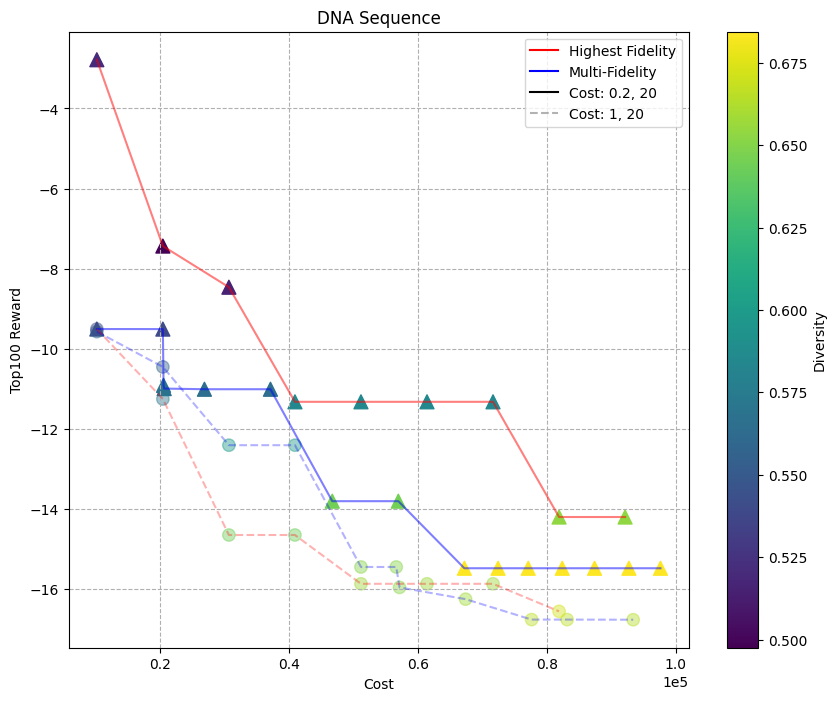

In [63]:
# Create a single subplot
fig, ax = plt.subplots(figsize=(10, 8))

# Plot the two line curves
mf_plot_good = ax.plot(mf_cost_good, mf_reward_good, color='blue', label='Multi-Fidelity', alpha=0.5)
sf_plot_good = ax.plot(sf_cost_good, sf_reward_good, color='red', label='Highest-Fidelity', alpha=0.5)

mf_plot_bad = ax.plot(mf_cost_bad, mf_reward_bad, color='blue', label='Multi-Fidelity', alpha=0.3, linestyle='--')
sf_plot_bad = ax.plot(sf_cost_bad, sf_reward_bad, color='red', label='Highest-Fidelity',alpha=0.3, linestyle='--')

# Set the title and axis labels
ax.set_title('DNA Sequence')
ax.set_xlabel('Cost')
ax.set_ylabel('Top{} Energy'.format(k))
# add grid
ax.grid(True, linestyle='--')
# convert cost labels to exponential
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))

# Add a legend
ax.legend(loc='upper right')

vmin = np.min([np.min(mf_diversity_bad), np.min(mf_diversity_good), np.min(sf_diversity_bad), np.min(sf_diversity_good)])
vmax = np.max([np.max(mf_diversity_bad), np.max(mf_diversity_good), np.max(sf_diversity_bad), np.max(sf_diversity_good)])
# Create a single ScalarMappable object for the colorbar
div_norm = Normalize(vmin=vmin, vmax=vmax)
div_cmap = coolwarm
div_cmap = 'viridis'
sm = plt.cm.ScalarMappable(cmap=div_cmap, norm=div_norm)
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=div_norm)


# Add scatter plots for both line curves and shade the points by diversity
mf_scatter_good = ax.scatter(mf_cost_good, mf_reward_good, c=mf_diversity_good, cmap=div_cmap, norm=div_norm, s=100, marker='^')
sf_scatter_good = ax.scatter(sf_cost_good, sf_reward_good, c=sf_diversity_good, cmap=div_cmap, norm=div_norm, s=100, marker='^')

mf_scatter_bad = ax.scatter(mf_cost_bad, mf_reward_bad, c=mf_diversity_bad, cmap=div_cmap, norm=div_norm, s=80, marker='o', alpha=0.43)
sf_scatter_bad = ax.scatter(sf_cost_bad, sf_reward_bad, c=sf_diversity_bad, cmap=div_cmap, norm=div_norm, s=80, alpha=0.43, marker='o')

# Create the custom legend
handles = [plt.Line2D([], [], color='r', linestyle='-'),
           plt.Line2D([], [], color='b', linestyle='-'), 
           plt.Line2D([], [], color='black', linestyle='-'),
            plt.Line2D([], [], color='black', linestyle='--', alpha=0.3),    ]
labels = ['Highest Fidelity', 'Multi-Fidelity', 'Cost: 0.2, 20', 'Cost: 1, 20']
ax.legend(handles, labels)

# # Create the two legend handles
# legend1 = ax.legend(loc='upper right', frameon=False)
# # legend2 = ax.legend(['', ''], ['Cost: 0.2, 20', 'Cost: 1, 20'], loc='lower right', frameon=False)

# # Add the legend handles to the figure
# fig.legend(handles=[legend1.legendHandles[0], legend1.legendHandles[1], legend1.legendHandles[2], legend1.legendHandles[3]], 
#            labels=['Highest', 'Multi-Fidelity', 'Cost: 0.2, 20', 'Cost: 1, 20'], loc='upper right')
# # fig.legend(handles=[mf_plot_good, sf_plot_good, mf_plot_bad, sf_plot_bad], 
#         #    labels=['Highest', 'Multi-Fidelity', 'Cost: 0.2, 20', 'Cost: 1, 20'], loc='upper right')

# Add a colorbar for the ScalarMappable object
cbar = fig.colorbar(sm)

# Set the label for the colorbar
cbar.ax.set_ylabel('Sequence Identity')


# Display the plot
plt.show()

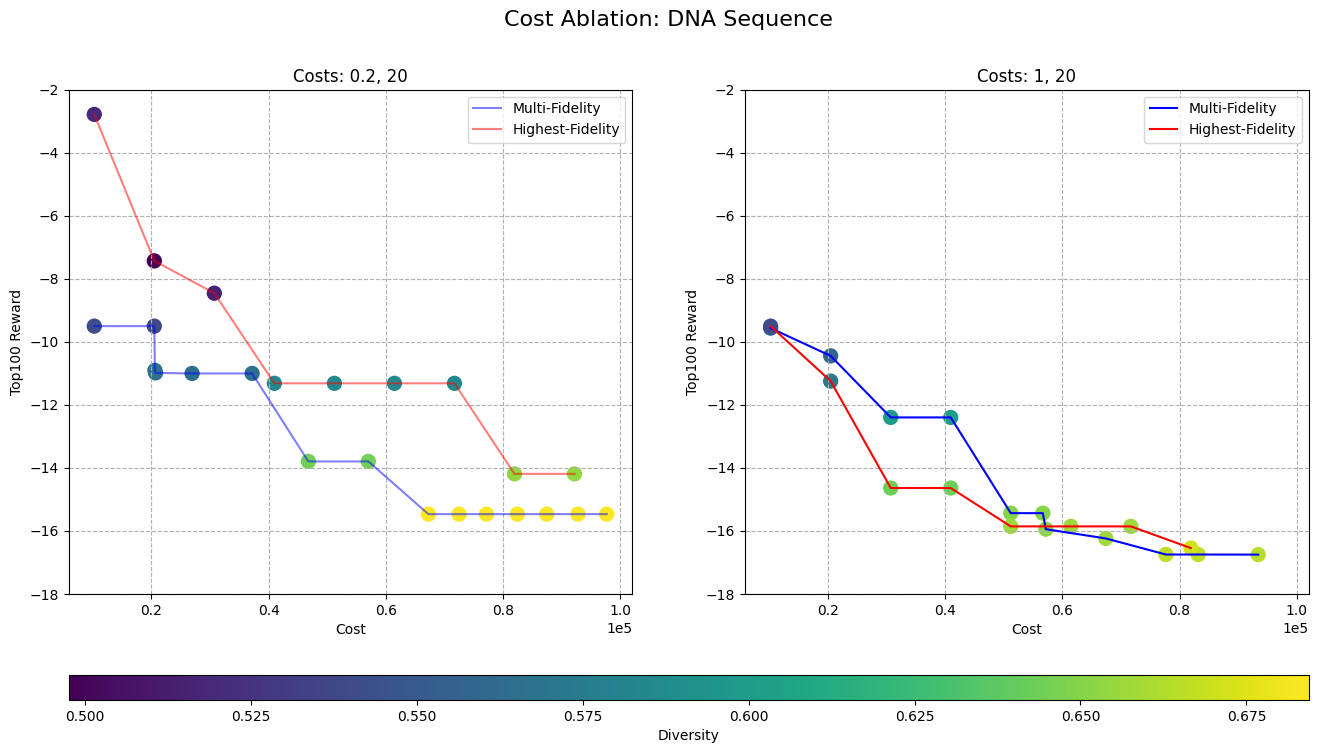

: 

In [113]:
# Create a single subplot
fig, axs = plt.subplots(1, 2, figsize=(16, 8), sharex=True)

# Plot the two line curves
mf_plot_good = axs[0].plot(mf_cost_good, mf_reward_good, color='blue', label='Multi-Fidelity', alpha=0.5)
sf_plot_good = axs[0].plot(sf_cost_good, sf_reward_good, color='red', label='Highest-Fidelity', alpha=0.5)
axs[0].set_title("Costs: 0.2, 20")

mf_plot_bad = axs[1].plot(mf_cost_bad, mf_reward_bad, color='blue', label='Multi-Fidelity')
sf_plot_bad = axs[1].plot(sf_cost_bad, sf_reward_bad, color='red', label='Highest-Fidelity')
axs[1].set_title("Costs: 1, 20")

# Set the title and axis labels
# ax.set_title('DNA Sequence')
for ax in axs:
    ax.set_xlabel('Cost')
    ax.set_ylabel('Top{} Energy'.format(k))
    ax.set_ylim([-18, -2])
    # add grid
    ax.grid(True, linestyle='--')
    # convert cost labels to exponential
    ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0))
    # ax.set_xlim([0e4, 1e5])

vmin = np.min([np.min(mf_diversity_bad), np.min(mf_diversity_good), np.min(sf_diversity_bad), np.min(sf_diversity_good)])
vmax = np.max([np.max(mf_diversity_bad), np.max(mf_diversity_good), np.max(sf_diversity_bad), np.max(sf_diversity_good)])
# Create a single ScalarMappable object for the colorbar
div_norm = Normalize(vmin=vmin, vmax=vmax)
div_cmap = coolwarm
div_cmap = 'viridis'
sm = plt.cm.ScalarMappable(cmap=div_cmap, norm=div_norm)
# sm = plt.cm.ScalarMappable(cmap='viridis', norm=div_norm)


# Add scatter plots for both line curves and shade the points by diversity
mf_scatter_good = axs[0].scatter(mf_cost_good, mf_reward_good, c=mf_diversity_good, cmap=div_cmap, norm=div_norm, s=100, marker='o')
sf_scatter_good = axs[0].scatter(sf_cost_good, sf_reward_good, c=sf_diversity_good, cmap=div_cmap, norm=div_norm, s=100, marker='o')

mf_scatter_bad = axs[1].scatter(mf_cost_bad, mf_reward_bad, c=mf_diversity_bad, cmap=div_cmap, norm=div_norm, s=100, marker='o')
sf_scatter_bad = axs[1].scatter(sf_cost_bad, sf_reward_bad, c=sf_diversity_bad, cmap=div_cmap, norm=div_norm, s=100, marker='o')

axs[0].legend()
axs[1].legend()

cbar = fig.colorbar(sm, ax=axs, orientation='horizontal', fraction=0.05, pad=0.05, aspect=50, location='bottom')
# cbar.ax.set_label_position('top')
# Set the size of the subplots to be the same
fig.subplots_adjust(bottom=0.25)
# cbar = fig.colorbar(sm)

# Set the label for the colorbar
# add colorbar to figure
cbar.set_label('Diversity')
# cbar.tick_params(labelbottom=True)

# add title to figure
fig.suptitle('Cost Ablation: DNA Sequence', fontsize=16)


# Display the plot
plt.show()